In [9]:
# import the necessary packages
import torch
import torchvision
from torchvision.transforms import ToTensor
from torchvision.datasets import KMNIST
from torch.utils.data import DataLoader, random_split
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from Models.LeNet import LeNet
from torchsummary import summary
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import os

In [2]:
# Configure hyperparameters
BATCH_SIZE = 32
EPOCHS     = 30
LR         = 1e-4

TRAIN_SPLIT = 0.90
VAL_SPLIT   = 0.10

# set the device we will  be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'[INFO] Device used: {device}')

print(f'[INFO] Loading datasets....')
fullTrainData = KMNIST(root = "data", train = True, download = False, transform = ToTensor())
TestData      = KMNIST(root = "data", train = False, download = False, transform = ToTensor())

counts = Counter(fullTrainData.targets.tolist())
print(f'[INFO] Train Data Info:')
for idx, class_name in enumerate(fullTrainData.classes):
    print(f'Class {idx+1 :2d} ({class_name}):\t {counts[idx]} images')

print(f'[INFO] Generating the train/val/test datasets')
totalSamples  = len(fullTrainData)
nTrainSamples = int(TRAIN_SPLIT*totalSamples)
nValSamples   = totalSamples-nTrainSamples

(trainData, valData) = random_split(
    fullTrainData, 
    [nTrainSamples, nValSamples],
    generator = torch.Generator().manual_seed(42)
)

# create the dataloaders
trainDataLoader = DataLoader(trainData, batch_size = BATCH_SIZE, shuffle = True)
valDataLoader   = DataLoader(valData, batch_size = BATCH_SIZE)
testDataLoader  = DataLoader(TestData, batch_size = BATCH_SIZE)

n_classes       = len(trainData.dataset.classes)

print(f'[INFO] Total images train/val: {nTrainSamples, nValSamples}')
print(f'[INFO] Total images test: {len(TestData)}')
print(f'[INFO] Num of classes: {n_classes}')
print(f'[INFO] Size of image: {trainData[0][0].shape}')

[INFO] Device used: cuda
[INFO] Loading datasets....
[INFO] Train Data Info:
Class  1 (o):	 6000 images
Class  2 (ki):	 6000 images
Class  3 (su):	 6000 images
Class  4 (tsu):	 6000 images
Class  5 (na):	 6000 images
Class  6 (ha):	 6000 images
Class  7 (ma):	 6000 images
Class  8 (ya):	 6000 images
Class  9 (re):	 6000 images
Class 10 (wo):	 6000 images
[INFO] Generating the train/val/test datasets
[INFO] Total images train/val: (54000, 6000)
[INFO] Total images test: 10000
[INFO] Num of classes: 10
[INFO] Size of image: torch.Size([1, 28, 28])


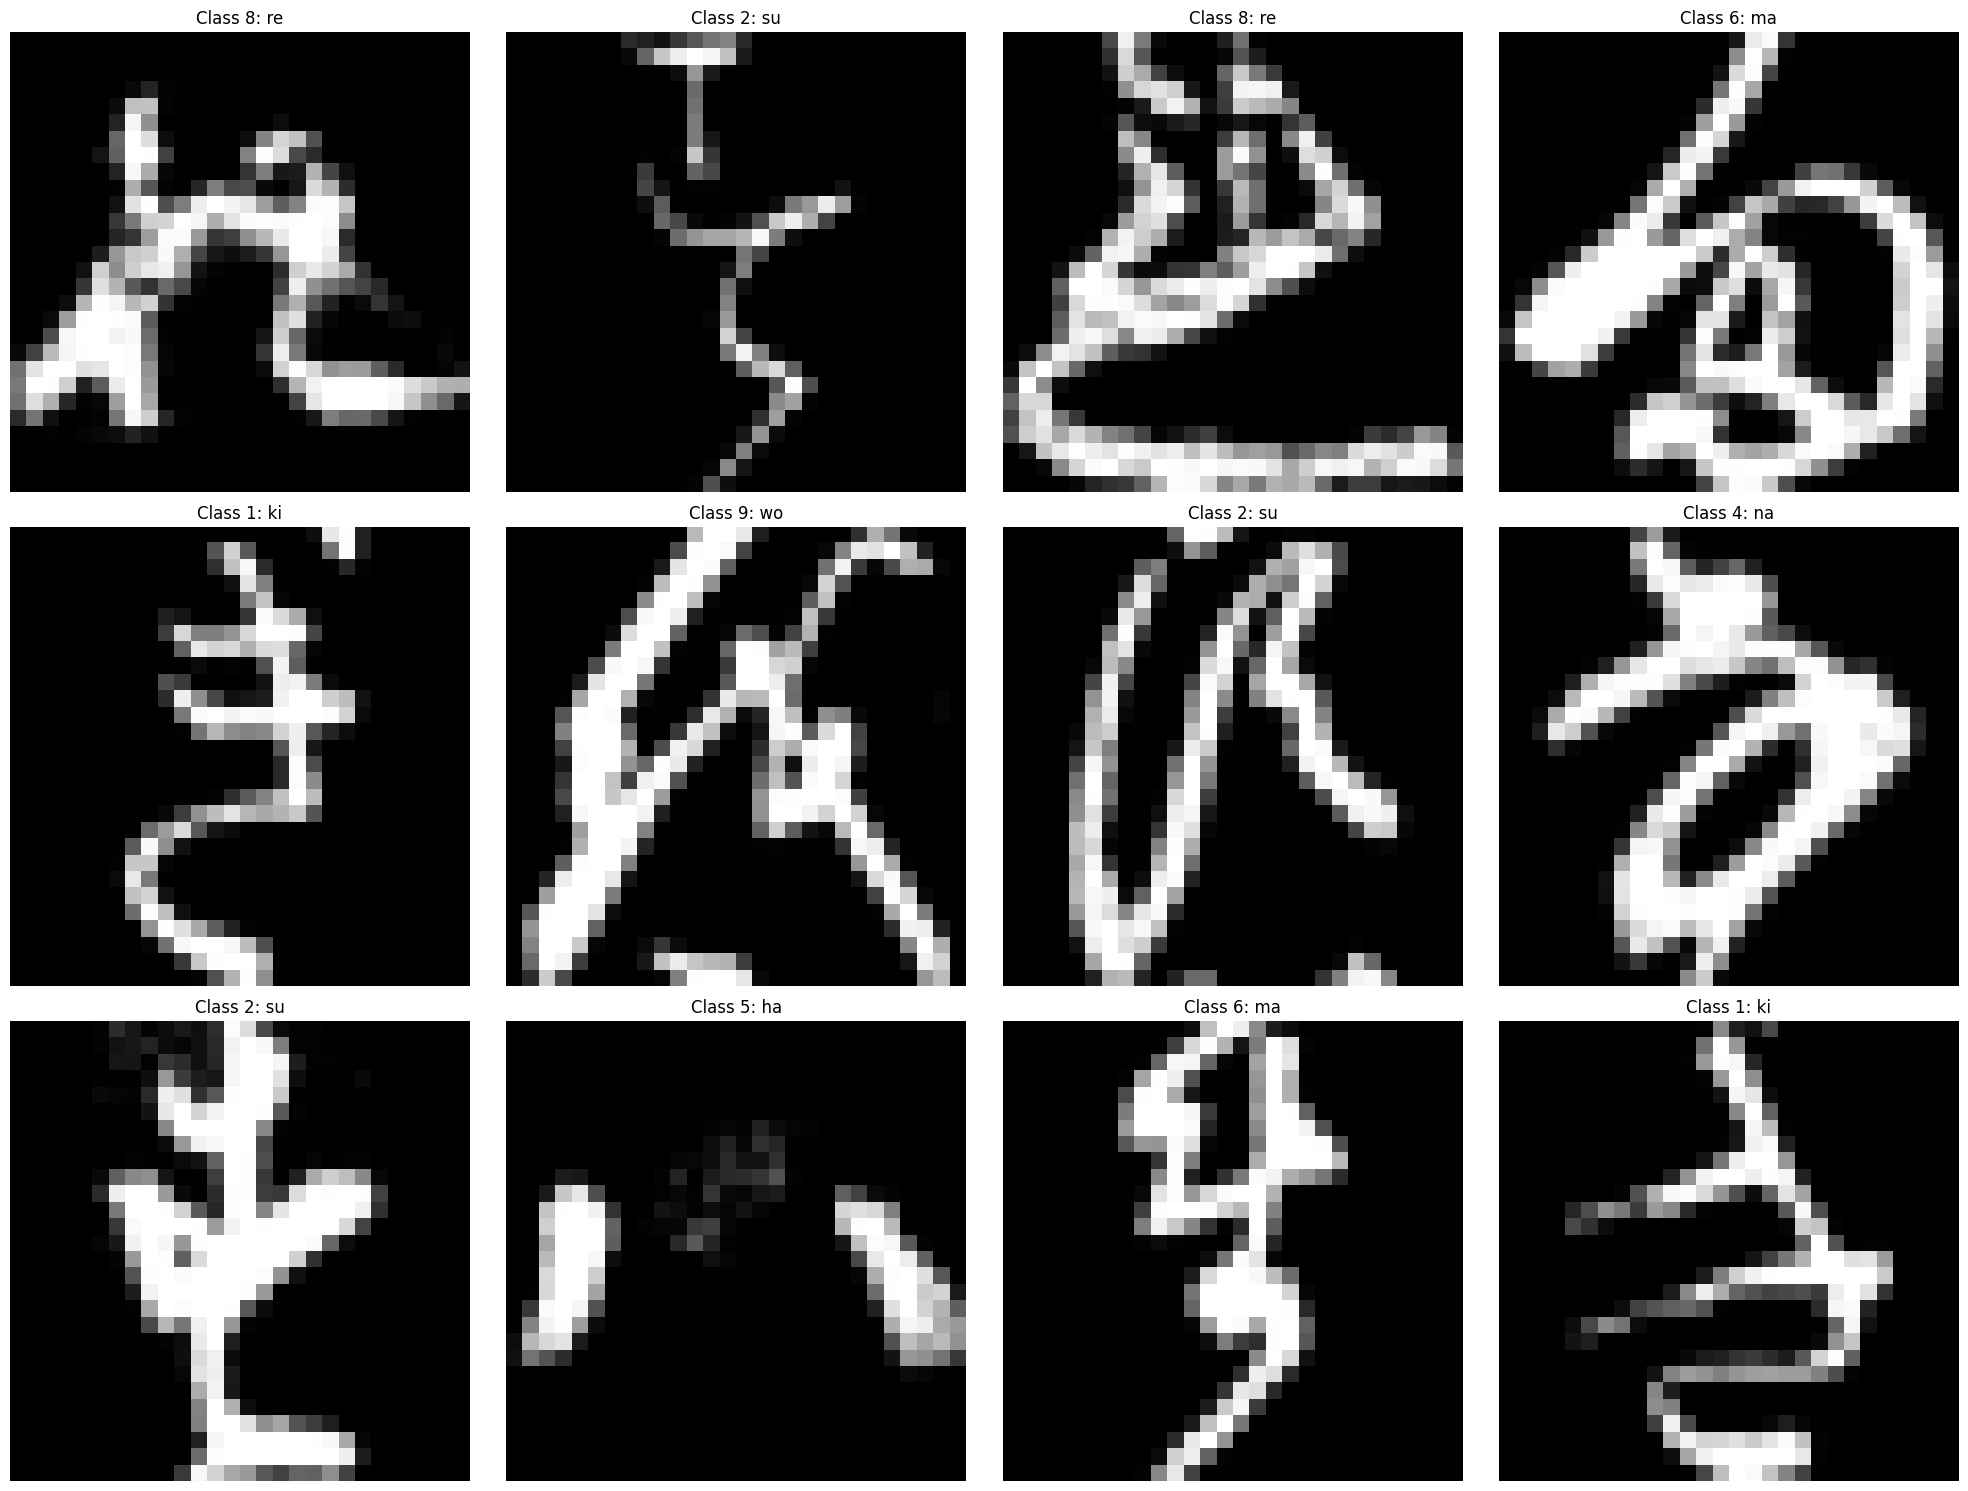

In [3]:
# Visualize the images dataset
fig = plt.figure(figsize = (20, 15))
for i in range(12):
    img, label = valDataLoader.dataset[i]
    ax = fig.add_subplot(3, 4, i+1)
    ax.imshow(img.squeeze(0), cmap='gray')
    ax.set_title(f'Class {label}: {testDataLoader.dataset.classes[label]}')
    ax.set_axis_off()
plt.tight_layout()
plt.show()

In [4]:
# Initializing the model
print(f'[INFO] Initializing the model (LeNet) ...')
model  = LeNet(nChannels = 1, nclasses = n_classes).to(device)
opt    = Adam(model.parameters(), lr = LR)
lossFn = CrossEntropyLoss()

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

summary(model, input_size = trainDataLoader.dataset[0][0].shape)

[INFO] Initializing the model (LeNet) ...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
              ReLU-2            [-1, 6, 24, 24]               0
         MaxPool2d-3            [-1, 6, 12, 12]               0
            Conv2d-4             [-1, 16, 8, 8]           2,416
              ReLU-5             [-1, 16, 8, 8]               0
         MaxPool2d-6             [-1, 16, 4, 4]               0
            Linear-7                  [-1, 120]          30,840
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
-------------------------------------------------------

In [5]:
print(f'[INFO] Training the model...')

for i in range(0, EPOCHS):
    model.train()

    total_train_loss = 0.0
    total_val_loss   = 0.0

    train_correct    = 0.0
    val_correct      = 0.0

    for img, label in trainDataLoader:
        (img, label) = (img.to(device), label.to(device))
        pred         = model(img)
        loss         = lossFn(pred, label)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_train_loss += loss
        train_correct    += (pred.argmax(1) == label).type(torch.float).sum().item()
    
    with torch.no_grad():
        model.eval()

        for img, label in valDataLoader:
            (img, label) = (img.to(device), label.to(device))
            pred         = model(img)

            total_val_loss += lossFn(pred, label)
            val_correct    += (pred.argmax(1) == label).type(torch.float).sum().item()
    
    mean_train_loss = total_train_loss / (len(trainDataLoader.dataset)//BATCH_SIZE)
    mean_val_loss   = total_val_loss / (len(valDataLoader.dataset)//BATCH_SIZE)

    train_correct   = train_correct / (len(trainDataLoader.dataset))
    val_correct     = val_correct / (len(valDataLoader.dataset))

    history["train_loss"].append(mean_train_loss.cpu().detach().numpy())
    history["train_acc"].append(train_correct)
    history["val_loss"].append(mean_val_loss.cpu().detach().numpy())
    history["val_acc"].append(val_correct)

    print(f'[INFO] Epoch: {i+1}/{EPOCHS}')
    print(f'\t Train loss: {mean_train_loss:.6f}, \t Train acc: {train_correct:.6f}')
    print(f'\t Val loss: {mean_val_loss:.6f}, \t Val acc: {val_correct:.6f}')

[INFO] Training the model...
[INFO] Epoch: 1/30
	 Train loss: 1.063320, 	 Train acc: 0.661778
	 Val loss: 0.670558, 	 Val acc: 0.794000
[INFO] Epoch: 2/30
	 Train loss: 0.551829, 	 Train acc: 0.829611
	 Val loss: 0.484965, 	 Val acc: 0.852167
[INFO] Epoch: 3/30
	 Train loss: 0.424532, 	 Train acc: 0.869722
	 Val loss: 0.412167, 	 Val acc: 0.872667
[INFO] Epoch: 4/30
	 Train loss: 0.350624, 	 Train acc: 0.892611
	 Val loss: 0.366508, 	 Val acc: 0.888167
[INFO] Epoch: 5/30
	 Train loss: 0.299692, 	 Train acc: 0.909056
	 Val loss: 0.309940, 	 Val acc: 0.907167
[INFO] Epoch: 6/30
	 Train loss: 0.263286, 	 Train acc: 0.919407
	 Val loss: 0.282838, 	 Val acc: 0.915333
[INFO] Epoch: 7/30
	 Train loss: 0.236433, 	 Train acc: 0.927407
	 Val loss: 0.256589, 	 Val acc: 0.922333
[INFO] Epoch: 8/30
	 Train loss: 0.213208, 	 Train acc: 0.935741
	 Val loss: 0.234912, 	 Val acc: 0.931000
[INFO] Epoch: 9/30
	 Train loss: 0.195514, 	 Train acc: 0.941056
	 Val loss: 0.219444, 	 Val acc: 0.937000
[INFO] E

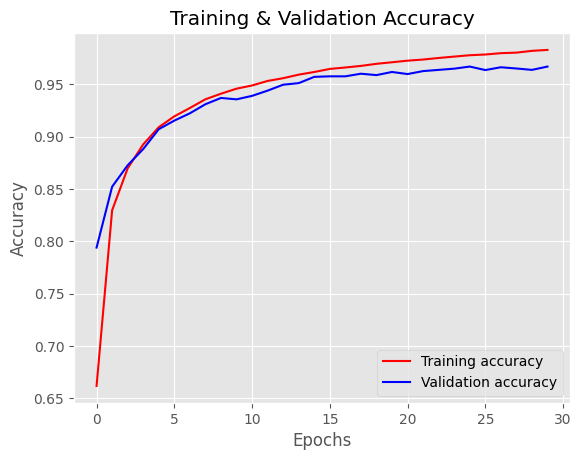

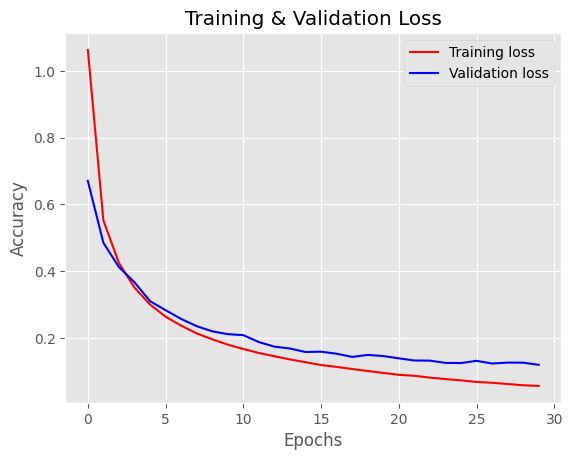

In [6]:
plt.style.use("ggplot")
# ------------------------------------------------------------------
# plot the training and validation accuracy
# ------------------------------------------------------------------
plt.figure()
plt.plot(history["train_acc"], color = 'r', label = "Training accuracy")
plt.plot(history["val_acc"], color = 'b', label = "Validation accuracy")
plt.title("Training & Validation Accuracy")
plt.legend(loc = 0)
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()
# ------------------------------------------------------------------
# plot the training and validation loss
# ------------------------------------------------------------------
plt.figure()
plt.plot(history["train_loss"], color = 'r', label = "Training loss")
plt.plot(history["val_loss"], color = 'b', label = "Validation loss")
plt.title("Training & Validation Loss")
plt.legend(loc = 0)
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

[INFO] Evaluating the model...
              precision    recall  f1-score   support

           o       0.95      0.93      0.94      1000
          ki       0.94      0.89      0.92      1000
          su       0.91      0.85      0.88      1000
         tsu       0.90      0.97      0.93      1000
          na       0.90      0.91      0.90      1000
          ha       0.96      0.89      0.93      1000
          ma       0.80      0.97      0.88      1000
          ya       0.95      0.92      0.94      1000
          re       0.93      0.93      0.93      1000
          wo       0.97      0.90      0.94      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



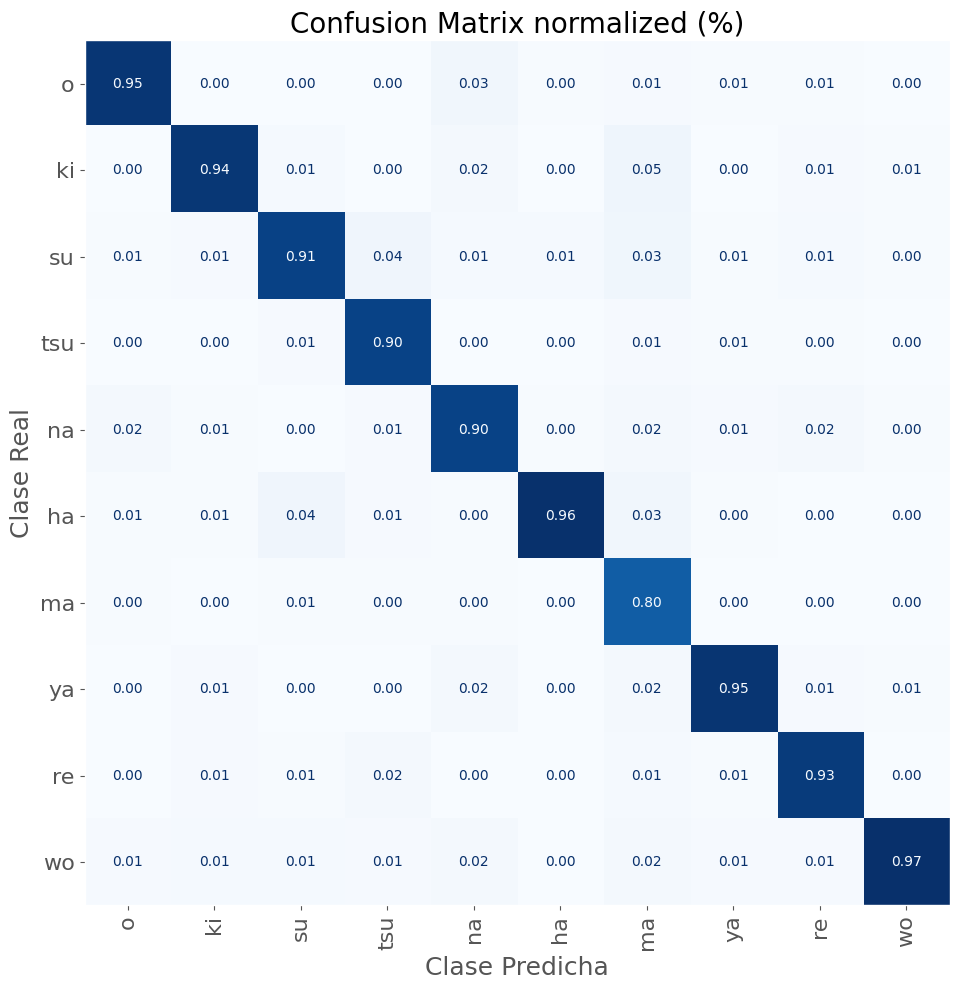

In [13]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

print(f'[INFO] Evaluating the model...')

with torch.no_grad():
    model.eval()
    probs = []
    true_labels = []

    for x, y in testDataLoader:
        x = x.to(device)
        y = y.to(device)

        outputs = model(x)
        preds   = outputs.argmax(dim=1)
        probs.extend(preds.cpu().numpy())
        true_labels.extend(y.cpu().numpy())

print(
    classification_report(
    true_labels, np.array(probs), target_names=TestData.classes
    )
)

folder = 'Resultados_Graficos'
os.makedirs(folder, exist_ok = True)
ext_file  = ".png"
name_file = "confusion_matrix" + ext_file
path_file = os.path.join(folder, name_file)

fig, ax= plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(
        true_labels, probs, display_labels=TestData.classes, xticks_rotation="vertical",
        normalize="pred",
        ax=ax, colorbar=False, cmap="Blues", values_format='.2f')
plt.tick_params(axis="both", labelsize = 16)
plt.ylabel("Clase Real", fontsize=18)
plt.xlabel("Clase Predicha", fontsize=18)
plt.title("Confusion Matrix normalized (%)", fontsize = 20)
plt.grid(False)
plt.tight_layout()
plt.savefig(path_file, dpi = 800, bbox_inches = "tight")